<a href="https://colab.research.google.com/github/andreveit/credit_card_fraud_detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   **Author:** Andre Veit

   **LinkedIn:** https://www.linkedin.com/in/andreveit/

   **E-mail:** andrev.veit@gmail.com

# **CREDIT CARD FRAUD DECTECTION**

# **Classification of Imbalanced Data and Anomaly Detection**







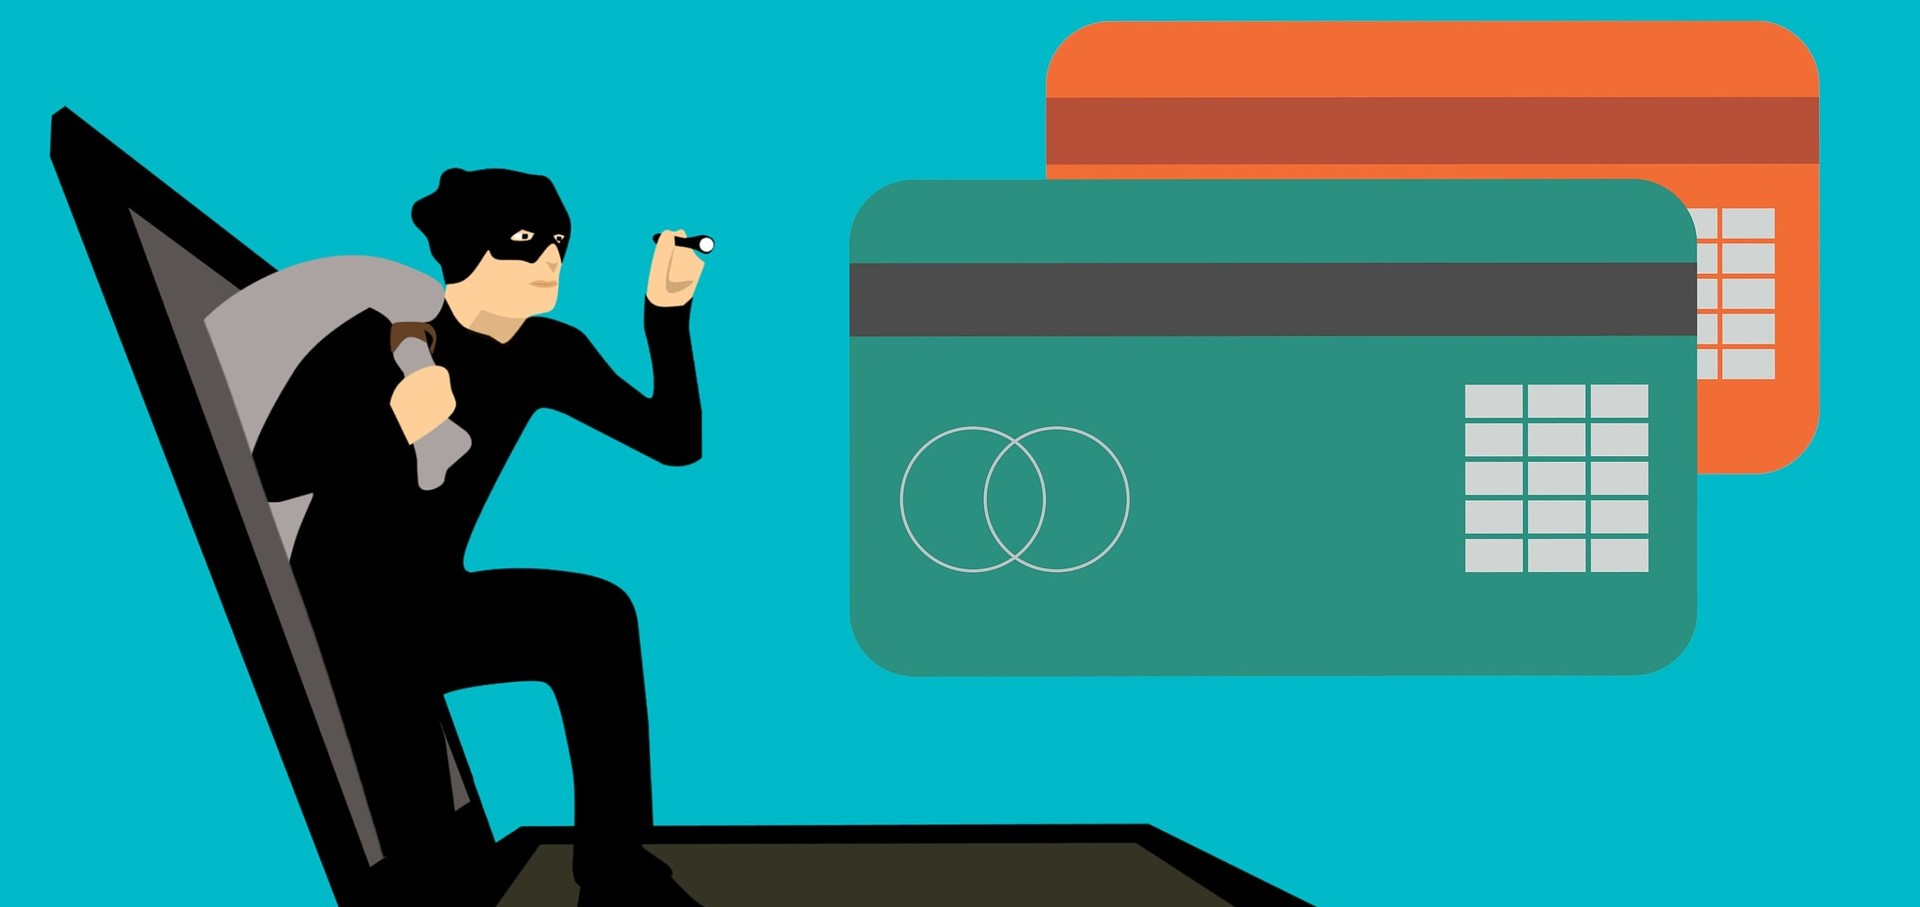

# **About this notebook**


Fraud is not something new, in a matter of fact, according to Your Money website, the first fraud register happened back in 300 BC. Now a days, in a world where the internet and digitalization is increasing at an unbelievable rate, millions of transactions and other operations are realized every day through the network. That means many opportunities for fraudsters. 

Fortunately, there are relatively few. Unfortunately... this fact makes extremely hard to catch them. 

The objective of this notebook is to explore a few methods to deal with anomaly detection and highly imbalanced data sets.

<br>
<br>

### **Overview:**

1. Data Exploration and Preparation
2. Unsupervised Learning - Anomaly Detection
>2.1. Isolation Forest<br>
>2.2. Local Outlier Factor
3. Supervised Learning - Classification
>3.1. Logistic Regression<br>
>3.2. Random Forest<br>
>3.3. Support Vector Machines
4. Autoencoder - Unsupervised and  Semi-Supervised Learning
>4.1. Unsupervised Learning<br>
>4.2. Semi-Supervised Learning<br>

# Data Set

This dataset is from Kaggle website and can be found though the link:

https://www.kaggle.com/mlg-ulb/creditcardfraud


Below the data description from the original source.

<br>
<br>

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<br>

## Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<br>

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

<br>

## Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

<br>

**Please cite the following works:**

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

In [201]:
#Importing main libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import plotly.express as px
import sklearn
from IPython.display import clear_output

#Preprocessing
from sklearn import preprocessing
from sklearn import feature_selection
from imblearn import combine
from tempfile import mkdtemp
from joblib import Memory
import shutil
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

# !pip install imbalanced-learn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Visualization
from sklearn.manifold import TSNE

#Metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve

#Anomaly detection models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#Deep Learning models
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

sns.set_style("dark")

import warnings
warnings.filterwarnings("ignore")


SEED = 123
np.random.seed(SEED)

# Data Exploration and Preparation

In [2]:
#Load the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit Card Fraud Detection/creditcard.csv', parse_dates = ['Time'], infer_datetime_format=True)

In [3]:
#Rename columns
df.rename({'Class' : 'fraud', 'Time' : 'time', 'Amount' : 'amount'}, axis = 1, inplace = True)
df.columns

Index(['time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'amount',
       'fraud'],
      dtype='object')

In [4]:
df.shape

(284807, 31)

No null values, data types ok.

In [5]:
#Print info
df.time = pd.to_numeric(df.time, downcast='integer')
df.fraud = pd.to_numeric(df.fraud, downcast='integer')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  int32  
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995




---
<br>

### What we have so far

- The dataset contains 28 V-columns, plus "time", "amount" and the target variable "fraud".
- The dataset has 284807 observations and 31 columns.
- There are no missing values.
- All numeric columns are standardized except "time" and "amount".

<br>

---

## Further Exploration

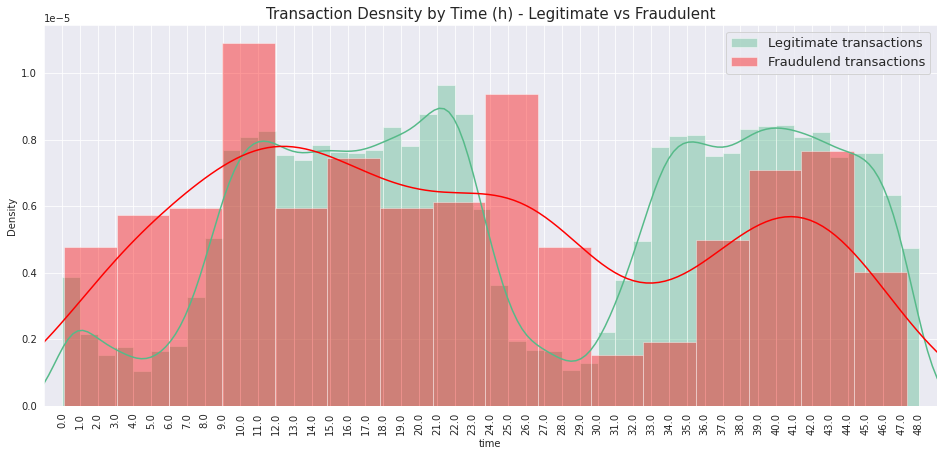

In [7]:
plt.figure(figsize=(16,7))

sns.distplot(df[df['fraud'] == 0]["time"], kde=True, color="#56ba89", label='Legitimate transactions',bins=48)
sns.distplot(df[df['fraud'] == 1]["time"], color='r', label='Fraudulend transactions', bins=16)

plt.title('Transaction Desnsity by Time (h) - Legitimate vs Fraudulent', fontsize=15)
plt.xticks(ticks=np.arange(0,df['time'].max()+3600,3600), labels=np.arange(0,df['time'].max()+3600,3600)/3600, rotation=90)
plt.xlim([-3600,49*3600])
plt.grid()
plt.legend(fontsize=13)

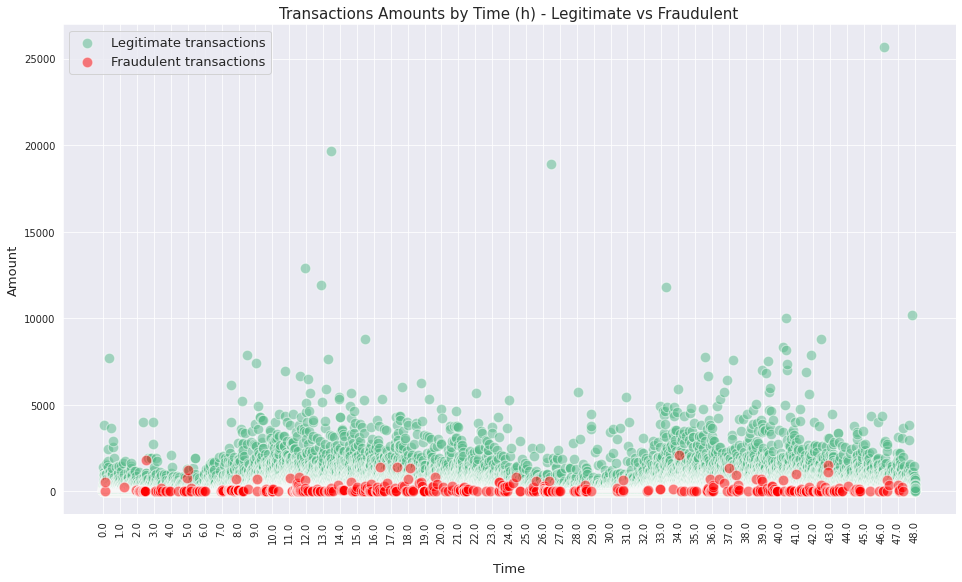

In [8]:
fig = plt.figure(figsize=(16,9))
plt.scatter(x=df[df['fraud']==0]['time'], y=df[df['fraud']==0]['amount'], alpha=0.5, color='#56ba89', label='Legitimate transactions', s=110, edgecolors='w')
plt.scatter(x=df[df['fraud']==1]['time'], y=df[df['fraud']==1]['amount'], alpha=0.5, color='red', label='Fraudulent transactions',s=110, edgecolors='w')
plt.xticks(ticks=np.arange(0,df['time'].max()+3600,3600), labels=np.arange(0,df['time'].max()+3600,3600)/3600, rotation=90)
plt.legend(fontsize=13)
plt.xlabel('\nTime', fontsize=13)
plt.ylabel('Amount', fontsize=13)
plt.title('Transactions Amounts by Time (h) - Legitimate vs Fraudulent', fontsize=15)
plt.grid()

[Text(0, 0, 'Legitimate'), Text(0, 0, 'Fraudulent')]

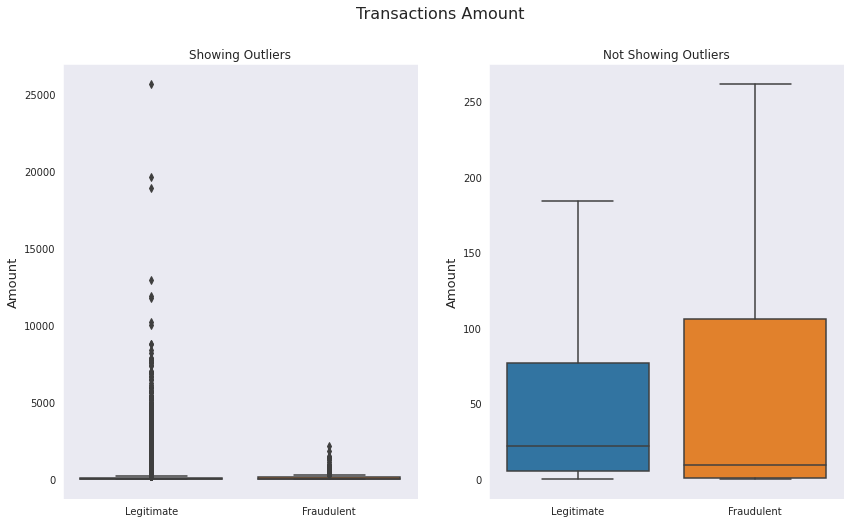

In [9]:
#Fraudulent/Legitimate "amount" distributions - Box plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))
fig.suptitle('Transactions Amount', fontsize=16)
s=sns.boxplot(data=df, x="fraud", y="amount", showfliers=True, ax=ax1)
ax1.set_xlabel('', fontsize=13)
ax1.set_ylabel('Amount', fontsize=13)
ax1.set_xticks(ticks=[0,1])
ax1.set_xticklabels(['Legitimate', 'Fraudulent'])
ax1.set_title('Showing Outliers')

s=sns.boxplot(data=df, x="fraud", y="amount", showfliers=False, ax=ax2)
ax2.set_title('Not Showing Outliers')
ax2.set_xlabel('', fontsize=13)
ax2.set_ylabel('Amount', fontsize=13)
ax2.set_xticks(ticks=[0,1])
ax2.set_xticklabels(['Legitimate', 'Fraudulent'])

Although there are some visible outliers in the plots, they will not be treated for now, as the features "amount" and "time" will be standardized in the following steps. Therefore their effect will be reduced.

It is worth to mention though, it should be a good starting point to further investigate if one wants to improve their model's performance.

<br>

Below we can see the statistics from Fraudulent vs Legitimate transactions regarding the "amount" variable. It is also displayed the distribution between the two categories (Fraud / Legit). Out of the 284807 observations, only 429 are actually fraudulent, which means 0.17 %. 

The following bar plot also explicits this imbalanced distribution.

The high imbalanced data distribution has a huge impact in the data analysis and modeling, hence it needs to be handled properly. 

In [10]:
#Amount and observations statistics - Fraudulent vs Legitimate
print('Fraudulent transactions:')
print(df[df.fraud == 1]['amount'].describe())
print()
print('Legitimate transactions:')
print(df[df.fraud == 0]['amount'].describe())
print()
print('Trasactions distribution:')
print('Legitimate transactions:',  round(df.fraud.value_counts(True).values[0] * 100, 2),  '%')
print('Fraudulent transactions:',  round(df.fraud.value_counts(True).values[1] * 100, 2),  '%')

Fraudulent transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: amount, dtype: float64

Legitimate transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: amount, dtype: float64

Trasactions distribution:
Legitimate transactions: 99.83 %
Fraudulent transactions: 0.17 %


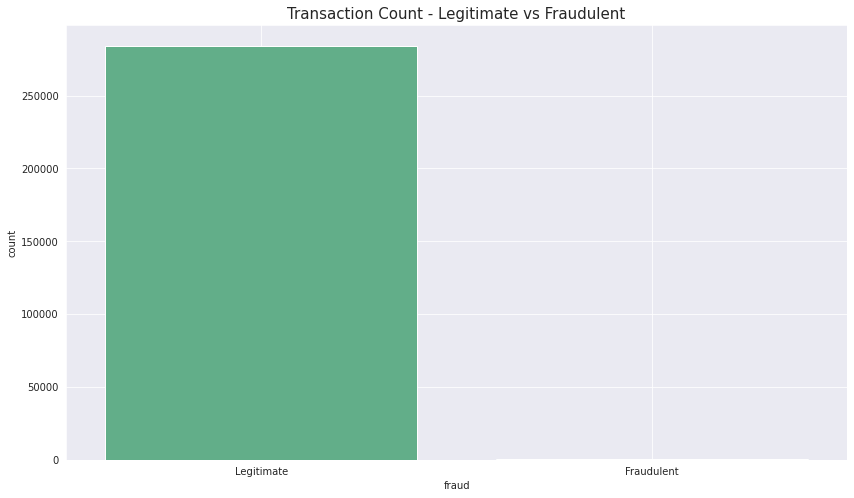

In [11]:
#Fraudulent/Legitimate observations distributions - Bar plot
plt.figure(figsize=(14,8))
sns.countplot(df["fraud"], color="#56ba89")
plt.title('Transaction Count - Legitimate vs Fraudulent', fontsize=15)
plt.xticks(ticks=[0,1], labels=['Legitimate', 'Fraudulent'])
plt.grid()

## Feature Selection

In [12]:
#Standardize the columns "time" and "amount"
scaler = preprocessing.StandardScaler()
scaled_cols = scaler.fit_transform(df[['time','amount']])
df[['time','amount']] = scaled_cols


#Get subset undersample dataframe
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=SEED)
subset_undersample, subset_target = undersample.fit_resample(df.drop(['fraud'],axis=1), df.fraud)
subset_undersample = pd.DataFrame(subset_undersample)
subset_undersample.columns = list(df.drop(['fraud'],axis=1).columns)


#Calculate correlations
corr_balanced = subset_undersample.corr()
corr_imbalanced = df.drop(['fraud'],axis=1).corr()


#Concatenate fraud column
subset_undersample = pd.concat([subset_undersample, pd.DataFrame(subset_target,columns=['fraud'])], axis=1)


#Feature selection metrics - Mutual Information and ANOVA
mi = feature_selection.mutual_info_classif(subset_undersample.drop(columns='fraud'),subset_undersample.fraud)
f_cls = feature_selection.f_classif(subset_undersample.drop(columns='fraud'),subset_undersample.fraud)
f_cls = f_cls[1]
f_cls_sig = f_cls <= 0.05

In order to visualize the correlation between features through a heat map, a subsample data set needs to be built, in this case undersampling the majority class (Legitimate) to obtain an equally distributed set.
 
 
Two Correlation Matrices are plotted, one generated with the balanced subset and the other one with the original dataset. Note that for the imbalanced matix it is not possible to see significant correlations between variables.
 
For the balanced matrix though, we see stronger correlations (positive and negative) for the group of features between V1 and V18.




Text(0.5, 1.0, 'Original Set - Imbalanced')

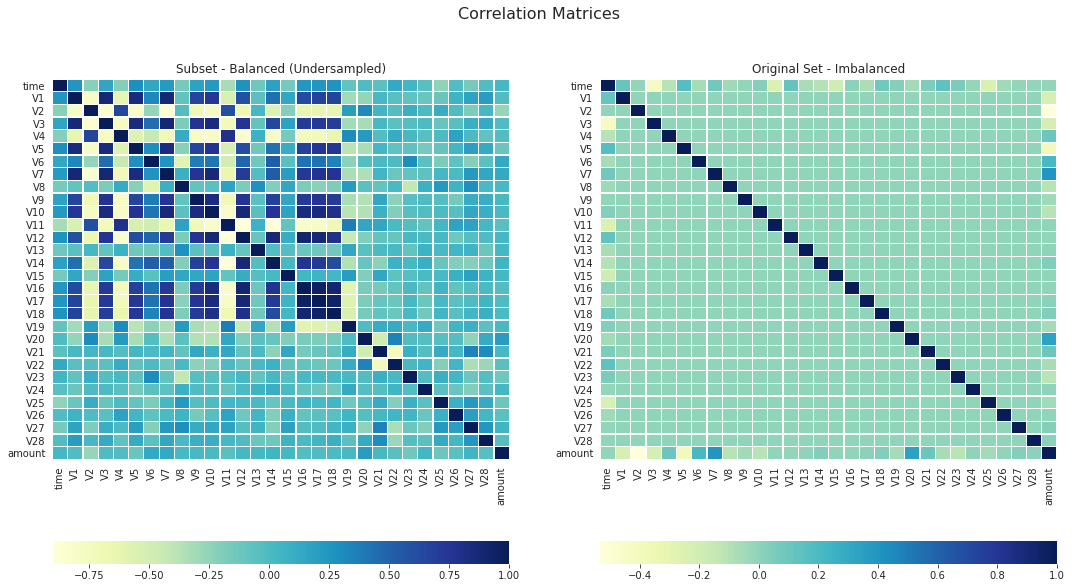

In [13]:
#Plot correlation matrices
sns.color_palette("vlag", as_cmap=True)
sns.set_palette("vlag")
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,10))
fig.suptitle('Correlation Matrices', fontsize=16)

ax1 = sns.heatmap(corr_balanced, ax=ax1, linewidths=.2, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"})
ax1.set_title('Subset - Balanced (Undersampled)')

ax2 = sns.heatmap(corr_imbalanced, linewidths=.2, ax=ax2, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"})
ax2.set_title('Original Set - Imbalanced')


Here we dive deeper into the features distribution exploration for Legitimate vs Fraudulent transactions. Note that some variables distributions do not significantly change for the two classes, hence they do not improve the information gain for fraud prediction.
 
Below it was plotted the scores of two feature selection tests, Mutual Information and F-test (ANOVA).
 
<br>
 
**Mutual Information:** <br>
Estimates the mutual information between a feature and the target variable. It measures the dependency between them. The higher, the more dependent the feature is with regard to the target and therefore its predictive power is higher.
 
<br>
 
**F-test - ANOVA:** <br>
Statistically compares the features mean over the two states (our classes) assuming a normal distribution, it captures a linear dependency. The values in the plot are the p-values for each feature. A low p-value (typically less than 0.05) means H0 can be discarded and the feature is significant.
<br>H0: Means are equal.
<br>H1: Means are different.

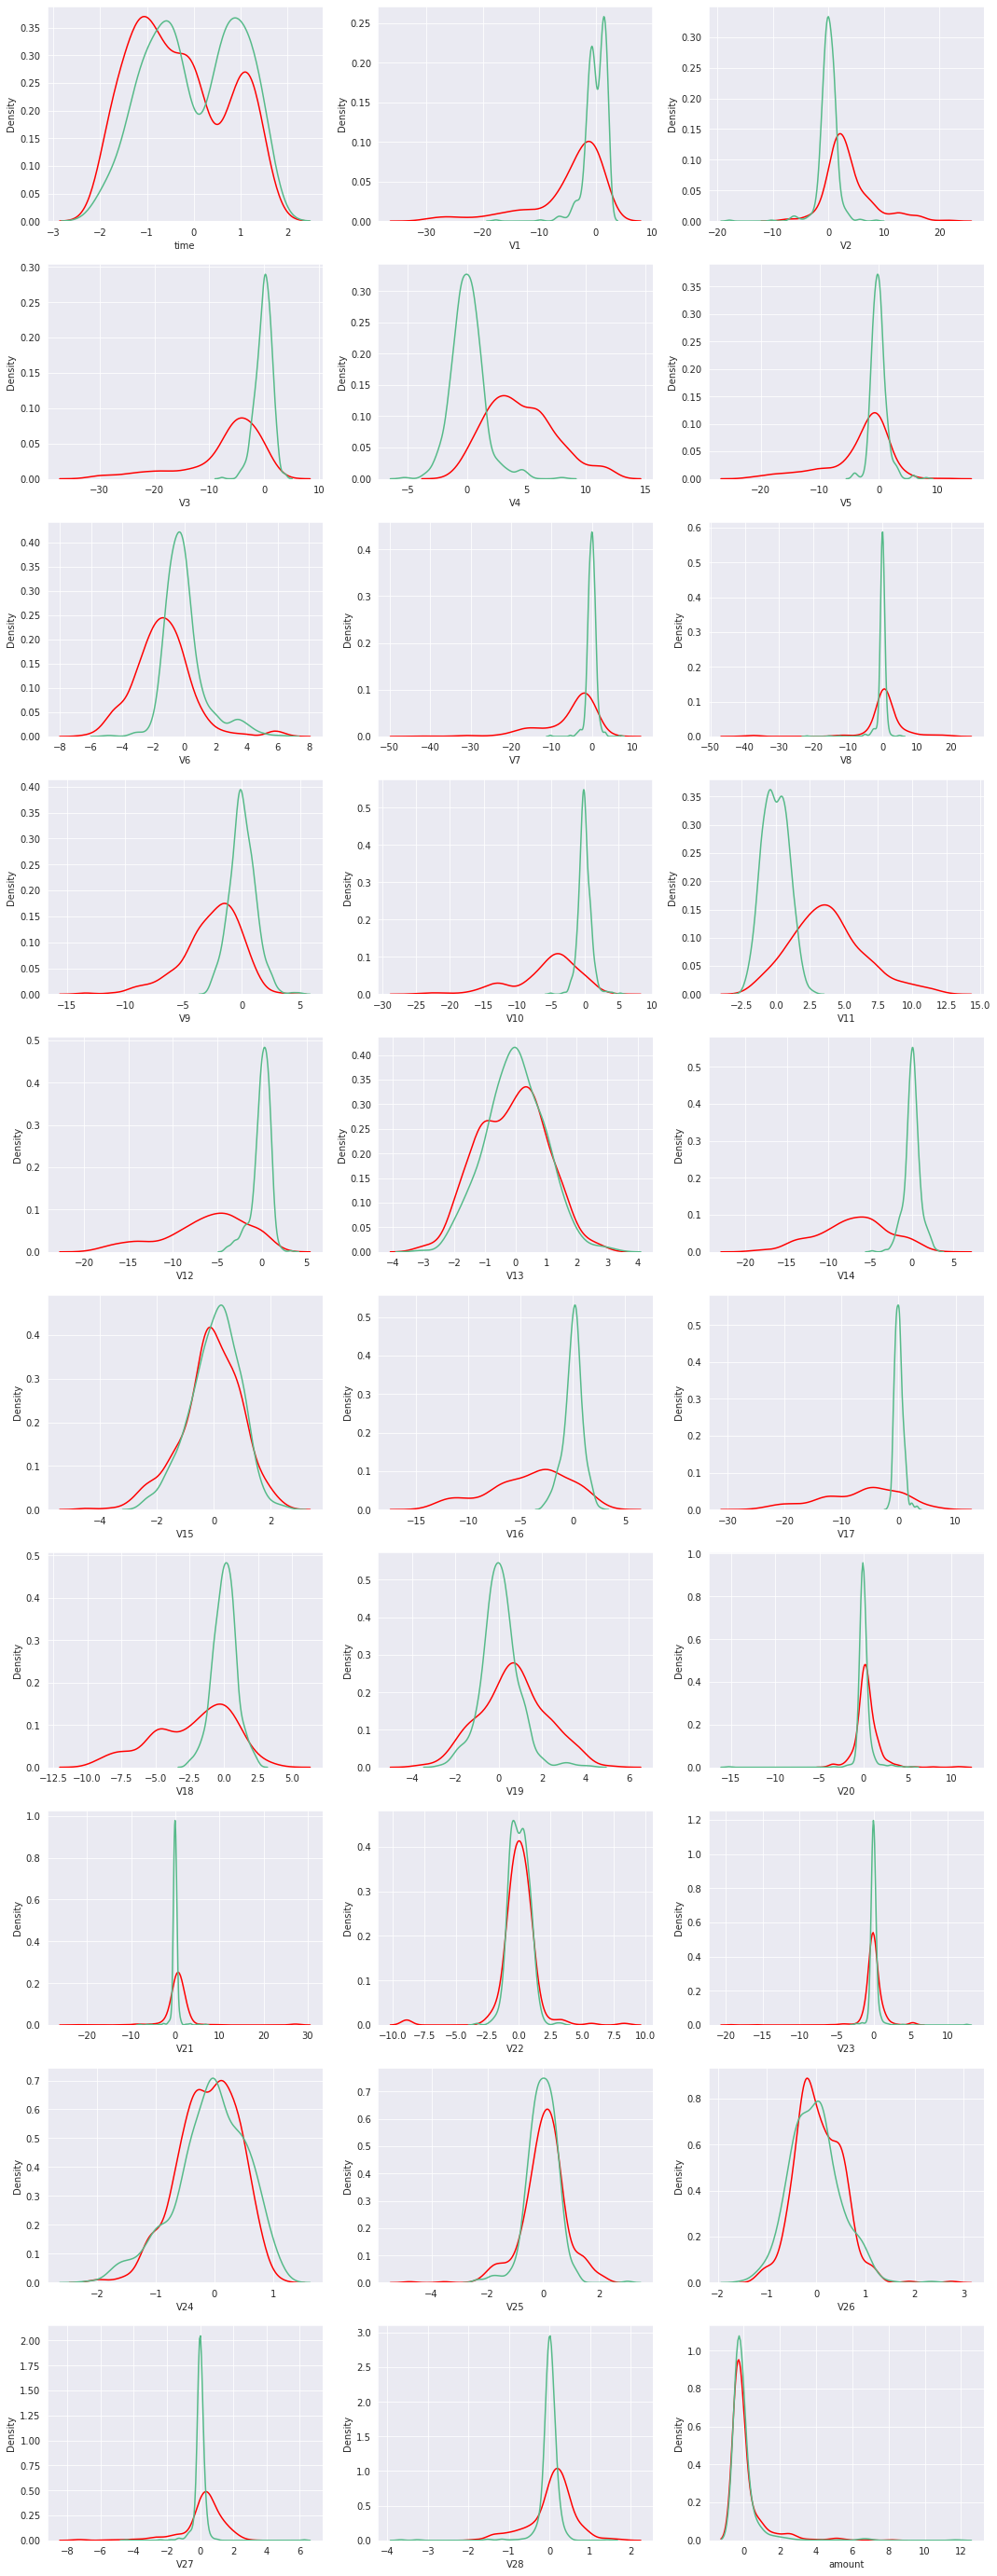

In [14]:
#Set figure
columns = subset_undersample.drop(columns='fraud').columns
n_lines = int(len(columns)/3) + (len(columns) % 3 > 0) #Round up
grid = gridspec.GridSpec(n_lines, 3)
plt.figure(figsize=(18,n_lines*5),constrained_layout=True)

#Loop over columns
for i, col in enumerate(subset_undersample[columns]):
  ax = plt.subplot(grid[i])
  sns.distplot(subset_undersample[subset_undersample.fraud==1][col], hist=False, color='red')
  sns.distplot(subset_undersample[subset_undersample.fraud==0][col], hist=False, color='#56ba89')
  ax.grid()
  ax.set_ylabel('Density')
  ax.set_xlabel(str(col))
plt.show()

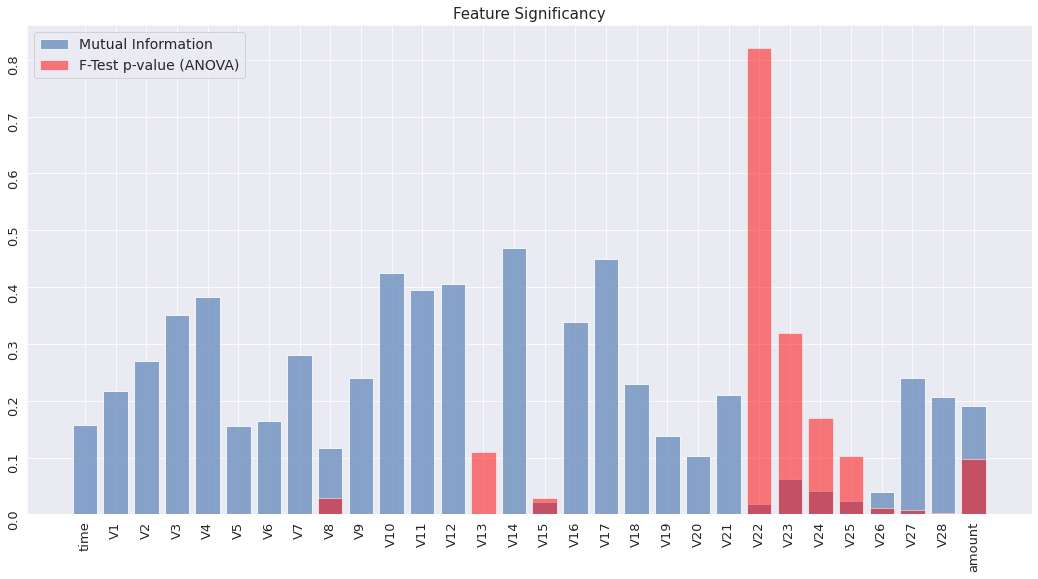

In [15]:
plt.figure(figsize=(18,9))
plt.bar(df.drop(columns='fraud').columns, mi, label='Mutual Information', alpha=0.8)
plt.bar(df.drop(columns='fraud').columns, f_cls, color='red', alpha=0.5, label='F-Test p-value (ANOVA)')
plt.legend(fontsize=14, loc=2)
plt.yticks(fontsize=13, rotation=90)
plt.xticks(fontsize=13, rotation=90)
plt.title('Feature Significancy', fontsize=15)
plt.grid()

In [16]:
#ANOVA results - alpha = 0.05
columns = subset_undersample.drop(columns='fraud').columns
print('F-test ANOVA results:\n')
for i, col in enumerate(columns):
  if f_cls_sig[i]:
    sig = 'Significant'
  else:
    sig = 'NOT SIGNIFICANT'
  print(col+':',sig)

F-test ANOVA results:

time: Significant
V1: Significant
V2: Significant
V3: Significant
V4: Significant
V5: Significant
V6: Significant
V7: Significant
V8: Significant
V9: Significant
V10: Significant
V11: Significant
V12: Significant
V13: NOT SIGNIFICANT
V14: Significant
V15: Significant
V16: Significant
V17: Significant
V18: Significant
V19: Significant
V20: Significant
V21: Significant
V22: NOT SIGNIFICANT
V23: NOT SIGNIFICANT
V24: NOT SIGNIFICANT
V25: NOT SIGNIFICANT
V26: Significant
V27: Significant
V28: Significant
amount: NOT SIGNIFICANT


### Feature Selection Results

After the analysis,  the following features will be considered non-significant:


- V13
- V15
- V22
- V23
- V25
- V26

In [17]:
#DataFrame Feature Selection
dffs = df.drop(columns=['V13', 'V15','V22','V23','V25','V26'])
dffs

,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V16,V17,V18,V19,V20,V21,V24,V27,V28,amount,fraud
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,-0.509348,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,-1.016226,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.640134,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.123205,0.108821,0.104533,-0.313249,0


## Training / Test Sets

At this stage, we split the data into training and test sets at a ratio of 4:1. Importantly, the split is made in a stratified way, ensuring that both sets will have the original distribution of fraud observations.

It will be generated two different groups of training/test sets, one using just the selected features and another one containing all the features. The fist one should be used for the supervised classification models. The second one should feed the autoencoder.



In [18]:

#Group of trainig/test sets - Supervised Classification Algorithms
X_train, X_test, y_train, y_test = train_test_split(dffs.drop(columns='fraud'),
                                                    dffs['fraud'],
                                                    test_size=0.25,
                                                    stratify=dffs['fraud'],
                                                    random_state=SEED)



#Group of trainig/test sets - Semi-Supervised Autoencoder Algorithm
train_enc, test_enc = train_test_split(df, test_size=0.25,  stratify=df['fraud'], random_state=SEED)

## Data Visualisation

### Dimensionality Reduction - t-SNE 

The algorithm t-SNE is a very important tool for data visualization of high-dimensional data. From the Scikit-Learn documentation:

"
t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

- Revealing the structure at many scales on a single map

- Revealing data that lie in multiple, different, manifolds or clusters

- Reducing the tendency to crowd points together at the center
"
<br>

Here it was used a undersampled set with class ratio of 10:1.
 
As the t-SNE method is based on a nearest-neighbor search, the data must be entirely standardized.

In [19]:
#Undersample the data
undersample_tnse = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
subset_undersample_tnse, subset_target_tsne = undersample_tnse.fit_resample(dffs.drop(['fraud'],axis=1), dffs.fraud)

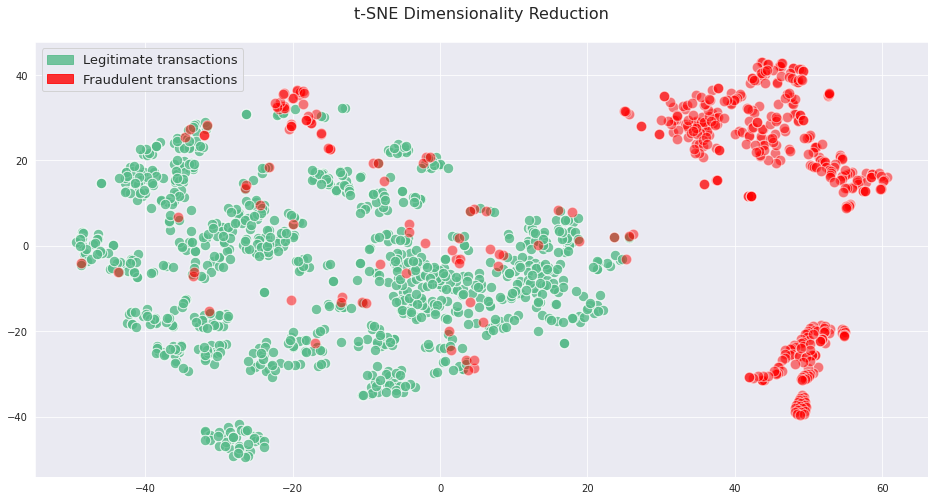

In [20]:
def plot_tsne(X_data, y_data):

  '''Plot t-SNE'''

  #Dimensionality Reduction - t-SNE
  X_tsne = TSNE(n_components=2, perplexity = 30, random_state=SEED).fit_transform(X_data)

  #Create df_tsne DataFrame
  df_tsne = pd.DataFrame(np.concatenate((X_tsne, y_data.reshape(-1,1)), axis=1))

  #Create figure
  fig, ax = plt.subplots(figsize=(16,8))
  nonfraud_patch = mpatches.Patch(color='#56ba89', label='Legitimate transactions', alpha = 0.8)
  fraud_patch = mpatches.Patch(color='red', label='Fraudulent transactions', alpha = 0.8)

  #Ligitimate points
  ax.scatter(df_tsne[df_tsne[2] == 0][0], df_tsne[df_tsne[2] == 0][1], c='#56ba89', alpha=.8, s=110, edgecolors='white')

  #Fraudulent points
  ax.scatter(df_tsne[df_tsne[2] == 1][0], df_tsne[df_tsne[2] == 1][1], c='red', alpha=.5, s=110, edgecolors='white')

  #Plot settings
  ax.grid()
  ax.set_title('t-SNE Dimensionality Reduction\n', fontsize=16)
  ax.legend(handles=[nonfraud_patch, fraud_patch], fontsize=13)



plot_tsne(subset_undersample_tnse, subset_target_tsne)

We can see that t-SNE did a fairly good job clustering the fraudulent observations while bringing them to a 2-dimensional space. However, there are some fraudulent samples that are still mixed among the legitimate ones. One cause for that might be lack of information. Note that less than 1% of the data was used, thus some considerable part of the information was not considered. There is also the possibility that t-SNE could not distinguish those fraudulent points from the legitimate ones.

# Unsupervised Learning - Anomaly Detection
In this section we implement two unsupervised algorithms for anomaly detection. The data to be input is the whole dataset without the labels. The chosen metric for performance evaluation is the f1-macro since it accounts for precision and recall from both classes.<br><br>

 $$f1_{Macro} =  \frac{1}{n} \sum \frac{2 * (Precision _i * Recall_i)}{(Precision_i + Recall_i)} $$

<br>

<br>

**Isolation Forest**<br>
Anomalies are observations that deviate from normal, hence there are few in numbers (the minority class). Also, their parameters differ from normal. Anomalies are **few** and **different**. That makes abnormal points easier to isolate in the space than the others. Isolation Forest measures the "isolability" and applies a threshold to classify observations as an anomaly.

<br>

**Local Outlier Factor**<br>
LOF identifies data points in low local density regions as outliers. The locality is given by k nearest neighbors and the local density is computed by the distance at which a point can be "reached" from its neighbors.

## Isolation Forest

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.6s finished



f1-macro:  0.647

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.30      0.29      0.29       492

    accuracy                           1.00    284807
   macro avg       0.65      0.65      0.65    284807
weighted avg       1.00      1.00      1.00    284807



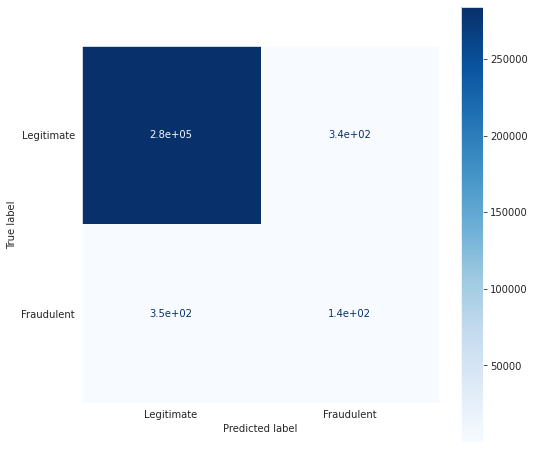

In [29]:
#Define the estimator
iforest = IsolationForest(n_estimators = 200, n_jobs = -1, verbose = 1, random_state = SEED, contamination=0.0017)

#Helper function
def anomaly_detector(estimator, X_data, y_data):
  '''Run anomaly detector estimator and display the results.'''
  
  y_pred = estimator.fit_predict(X_data)
  results = pd.DataFrame({'y_pred':y_pred,'y_data':y_data})
  results.y_pred = results.y_pred.apply(lambda x: 0 if (x==1) else 1)

  print('\nf1-macro: ', round(sklearn.metrics.f1_score(y_true=y_data, y_pred=results.y_pred,  average='macro'),3))
  print()
  print(classification_report(y_true=y_data, y_pred=results.y_pred))
  fig,ax =plt.subplots(figsize=(8,8))
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_data, y_pred=results.y_pred), display_labels=['Legitimate','Fraudulent'])
  disp.plot(ax=ax, cmap="Blues")



#Run the model over the entirely dataset
anomaly_detector(iforest, dffs.drop(columns='fraud'), dffs.fraud)

## Local Outlier Factor


f1-macro:  0.491

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.12      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.95      0.97    284807



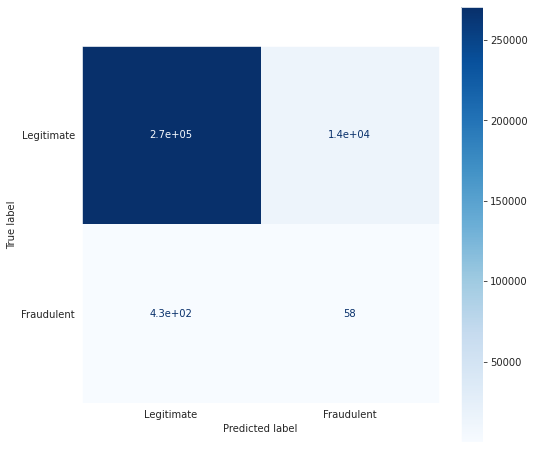

In [31]:
#Define the estimator
lof = LocalOutlierFactor(n_jobs=-1)

#Run the model over the entirely dataset
anomaly_detector(lof,  df.drop(columns='fraud'), df.fraud)

# Supervised Learning - Classification
As already seen earlier, the dataset classes are highly imbalanced. In general, there are three main ways to deal with this problem: weighting classes, anomaly detection algorithms or resampling methods.

In this section we are going to use resampling methods, two in particular will be applied to this dataset: Random-Undersampling and SMOTEENN.<br><br>

**Random-Undersampling:** simple method that randomly picks observations from the majority class and removes them. Here it will be applied first to our dataset, mainly to trim the amount of data and improve the results. According to Nitesh Chawla, et al., "The combination of SMOTE and under-sampling performs better than plain under-sampling." Moreover, it speeds up the training time.<br><br>

**SMOTEENN:** is the combination of two methods, Synthetic Minority Oversampling Technique (SMOTE) and Edited Nearest Neighbors (ENN).

> SMOTE oversamples the minority class creating synthetic new observations. It does that randomly selecting an observation and finding another one from the same class through Nearest-Neighbors. Then it places a new datapoint at some point in the line that connects them. According to the Imbalanced-Learn library documentation, "this method can generate noisy samples by interpolating new points between marginal outliers and inliers. This issue can be solved by cleaning the space resulting from over-sampling". 

> ENN filters the noise undersamping the data, is does that applying the Nearest-Neighbors algorithm to locate and discard misclassified observations.
<br>

<br>

Supervised learning algorithms need labeled data, so here we will be using the training and test datasets defined previously. 

As the objective is to generate a model capable of identify frauds in the real world, where the class distribution is imbalanced, the model must be tested on an imbalanced dataset. Besides, during hyperparameter tuning, our validation set should also be imbalanced. To do so, we will be using a pipeline.

But what the best metric to decide which model is better? Our primary objective is to identify as many frauds as we can, hence the Recall metric. However, it is equally important to be accurate and do not tag a legitimate transaction as a fraud, hence Precision. f1-macro is the simple average of the f1-score of each class, it computes precision and recall from both classes and therefore this will be the metric to be maximized.

Samplers' (transformers objects that undersample or oversample) parameters like class distributions ratios will also be grid searched during hyperparameter tuning. Bart Baesens in his book Fraud Analytics says: "...it is recommended to stay as close as possible to the original class distribution to avoid unnecessary bias.". The author proposes a method to find an optimal distribution by starting from the original class proportion and iteratively increase the relative amount of the minority class. That will be done through grid search.

<br>
<br>

Models be evaluated:

<br>

>**Logistic Regression**<br>
<br>
**Random Forest**<br>
<br>
**Support Vector Machines**<br>
<br>


**Note:** Strictly speaking, all data transformations made so far should be done inside the pipeline. As most of them were made by the dataset providers, that is not being considered.



<br>

**Helper functions**

In [41]:
#Helper functions
def plot_csl_results(estimator_gs, X_test, y_test, estimator_name):
  
  '''Display the classification results for analysis.'''
  
  clear_output()
  #Display best parameters from GridSearch
  print('Best params:')
  print(estimator_gs.best_params_)
  #Display metrics
  print('\nGeometric Mean Score on test (G-mean):', round(geometric_mean_score(y_test,estimator_gs.best_estimator_.predict(X_test)),3))
  print('Best score on train (f1-macro):',round(estimator_gs.best_score_,3))
  #Display report
  print()
  print(classification_report(y_test, estimator_gs.predict(X_test)))


  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
  #Plot ROC
  plot_roc_curve(estimator = estimator_gs, X = X_test, y = y_test, ax=ax1, name = estimator_name)
  ax1.set_title('Receiver Operating Characteristic Curve', fontsize=13)

  #Plot Precision-Recall Curve
  plot_precision_recall_curve(estimator = estimator_gs, X = X_test, y = y_test, ax=ax2, name = estimator_name)
  ax2.set_title('Precision Recall Curve', fontsize=13)

  #Plot Confusion Matrix
  plot_confusion_matrix(estimator = estimator_gs, X = X_test, y_true = y_test, ax=ax3, cmap="Blues")
  ax3.set_title('Confusion Matrix', fontsize=13)
  
  #Plot settings
  fig.suptitle(estimator_name+'\n', fontsize=15)
  ax1.grid()
  ax2.grid()
  
      
def run_classifier(X_train, y_train, X_test, y_test, estimator, sampler1, sampler2, params, metric_score, estimator_name="Classifier"):
  # metric_score = make_scorer(sklearn.metrics.f1_score)
  
  #Create cache file
  cachedir = mkdtemp()
  mem = Memory(location=cachedir, verbose=1)

  #Create pipeline
  steps = [('sampler1', sampler1), ('sampler2', sampler2), ('estimator', estimator)]
  pipe = Pipeline(steps=steps, memory=mem)

  #Grid search
  estimator_gs = GridSearchCV(pipe, params, scoring = metric_score, cv=5, n_jobs=-1).fit(X_train, y_train)

  #Display results
  plot_csl_results(estimator_gs, X_test, y_test, estimator_name)

  #Attempt to remove the temporary cachedir
  shutil.rmtree(cachedir, ignore_errors=True)

## Logistic Regression

Best params:
{'estimator__C': 0.005, 'estimator__penalty': 'l2', 'sampler1__sampling_strategy': 0.1, 'sampler2__sampling_strategy': 0.1}

Geometric Mean Score on test (G-mean): 0.841
Best score on train (f1-macro): 0.916

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.82      0.71      0.76       123

    accuracy                           1.00     71202
   macro avg       0.91      0.85      0.88     71202
weighted avg       1.00      1.00      1.00     71202



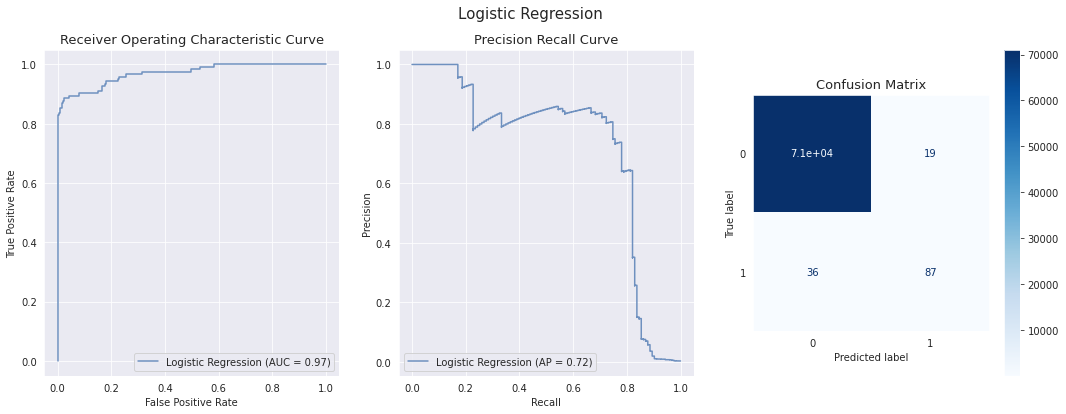

In [33]:
#-------------Model settings-------------------
estimator_name = 'Logistic Regression'
estimator = LogisticRegression(random_state=SEED, n_jobs=-1)
sampler1 = RandomUnderSampler(random_state=SEED)
sampler2 = combine.SMOTEENN(random_state=SEED)
metric_score = 'f1_macro'

# metric_score = geometric_mean_score
# sampler2 = SMOTE(random_state=SEED)

params = {'sampler1__sampling_strategy': [0.01, 0.1],
          'sampler2__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1],
          'estimator__C': [0.005, 0.01, 0.05, 0.08, 0.1, 0.15, 0.25],
          'estimator__penalty': ['l2']
          }

run_classifier(X_train, y_train,
               X_test, y_test,
               estimator,
               sampler1,
               sampler2,
               params,
               metric_score,
               estimator_name)

## Random Forest

Best params:
{'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 150, 'sampler1__sampling_strategy': 0.01, 'sampler2__sampling_strategy': 0.1}

Geometric Mean Score on test (G-mean): 0.901
Best score on train (f1-macro): 0.901

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.74      0.81      0.77       123

    accuracy                           1.00     71202
   macro avg       0.87      0.91      0.89     71202
weighted avg       1.00      1.00      1.00     71202



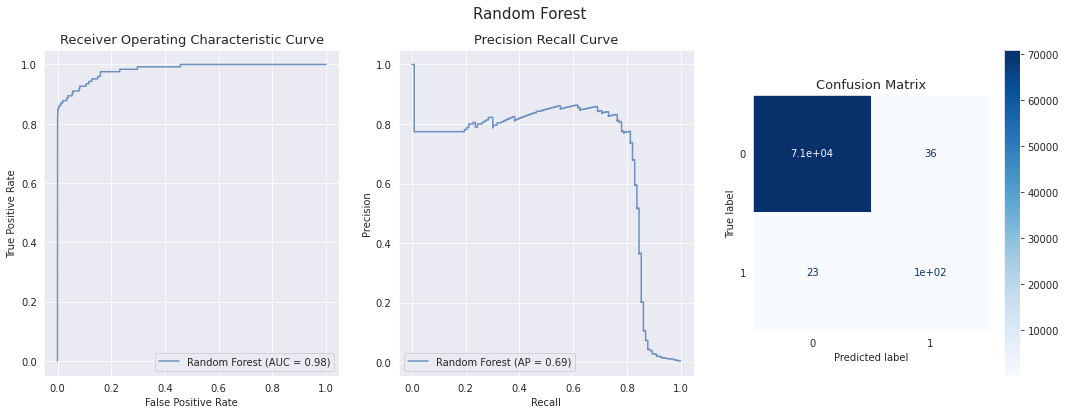

In [34]:
#-------------Model settings-------------------
estimator_name = 'Random Forest'
estimator = RandomForestClassifier(random_state=SEED, n_jobs=-1)
sampler1 = RandomUnderSampler(random_state=SEED)
sampler2 = combine.SMOTEENN(random_state=SEED)
metric_score = 'f1_macro'


params = {'sampler1__sampling_strategy': [0.01, 0.1],
          'sampler2__sampling_strategy': [0.1, 0.5, 1],
          'estimator__min_samples_split': [2,3],
          'estimator__min_samples_leaf': [4],
          'estimator__max_depth': [5,20,50,100,None],
          'estimator__n_estimators' : np.arange(150,250,50)
          }


run_classifier(X_train, y_train,
               X_test, y_test,
               estimator,
               sampler1,
               sampler2,
               params,
               metric_score,
               estimator_name)

## Support Vector Machines

Best params:
{'estimator__C': 0.01, 'estimator__penalty': 'l2', 'sampler1__sampling_strategy': 0.05, 'sampler2__sampling_strategy': 0.05}

Geometric Mean Score on test (G-mean): 0.855
Best score on train (f1-macro): 0.915

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.80      0.73      0.77       123

    accuracy                           1.00     71202
   macro avg       0.90      0.87      0.88     71202
weighted avg       1.00      1.00      1.00     71202



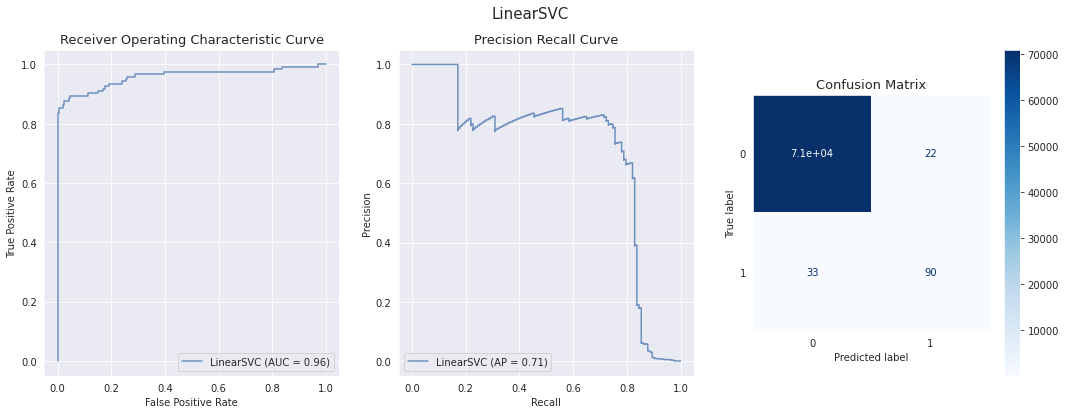

In [35]:
#-------------Model settings-------------------
estimator_name = 'LinearSVC'
estimator = LinearSVC(random_state=SEED)
sampler1 = RandomUnderSampler(random_state=SEED)
metric_score = 'f1_macro'
sampler2 = combine.SMOTEENN(random_state=SEED)


params = {'sampler1__sampling_strategy': [0.05, 0.1],
          'sampler2__sampling_strategy': [0.05, 0.1, 0.2, 0.25, 0.5],
          'estimator__C': [0, 0.01, 0.05, .1, .15],
          'estimator__penalty': ['l1', 'l2']
          }


run_classifier(X_train, y_train,
               X_test, y_test,
               estimator,
               sampler1,
               sampler2,
               params,
               metric_score,
               estimator_name)

# Autoencoder - Unsupervised and Semi-Supervised Learning

In this section, we are going to try to identify fraudulent transactions using Autoencoders. Autoencoder is an unsupervised deep-learning technique that aims to learn representations of the data (encoding). This neural network has a bottleneck where it compresses the information and forces a compact representation of the input data. The network has two parts, the encoder, responsible for the data compression, and the decoder, which reconstructs the data.

Autoencoders are trained to match the input and the output data. After trained they are used to several applications, such as denoising, dimensionality reduction, information retrieval, anomaly detection and others.

Here is a good article with more details about this network:
https://blog.keras.io/building-autoencoders-in-keras.html

<br>

As you would expect, we will use autoencoders as anomaly detectors.
It is going to be done using two different approaches, both are described in the following lines and you can follow along with the help of the chart below.

<br>

1. **Unsupervised Method:** <br>
The autoencoder is trained using only the legitimate transactions (*train_enc_Unsup*). Then, we pass the "*train_enc_Sup*" through, which contain both classes. As our model was trained with legitimate data only, it is expected that when it is fed with anomalous data (fraud), the quality of the reconstruction will decay. Therefore we compute the reconstruction error (MSE) and set a threshold. Finally, we test the method over the test set (*test_enc*).


2. **Semi-Supervised Method:** <br>
The semi-supervised method go one step further. Since it is expected the dataset to have a different feature space after reconstruction, a Random Florest model is trained as a final step. The classifier uses the data "*train_enc_Sup*" reconstructed by the autoencoder to train. Lastly, the results are evaluated on the "*test_enc*".


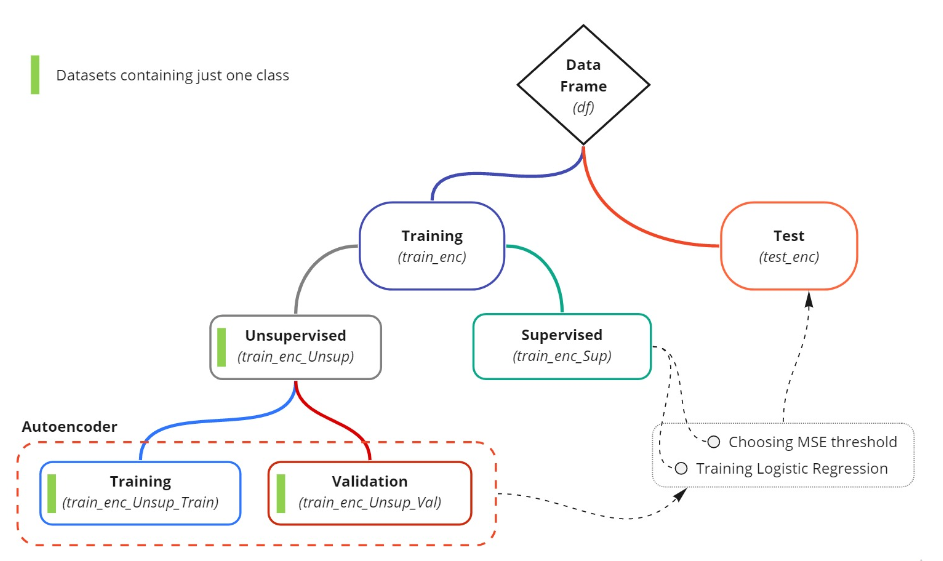

### Data Preprocessing

In [22]:
#Display data info
print('"train_enc" set:\n')
print('Shape:', train_enc.shape)
print('Pct fraud:', round(train_enc.fraud.value_counts(normalize=True)[1]*100,2),'%')
print('Pct split:', round(train_enc.shape[0] / (train_enc.shape[0]  +test_enc.shape[0])*100,2),'%')
print('\n')
print('"test_enc" set:\n')
print('Shape:', test_enc.shape)
print('Pct fraud:', round(test_enc.fraud.value_counts(normalize=True)[1]*100,2),'%')
print('Pct split:', round(test_enc.shape[0] / (train_enc.shape[0]  +test_enc.shape[0])*100,2),'%')

"train_enc" set:

Shape: (213605, 31)
Pct fraud: 0.17 %
Pct split: 75.0 %


"test_enc" set:

Shape: (71202, 31)
Pct fraud: 0.17 %
Pct split: 25.0 %


In [23]:
#Split the training data again. One part for Unsupervised training and other for Supervised training.
#Unsupervised training size
unsup_train_size = 0.5
train_enc_Sup, train_enc_Unsup = train_test_split(train_enc, test_size = unsup_train_size,  stratify = train_enc['fraud'], random_state=SEED)

#Get the legitimate samples from train_enc_Unsup - Encoder will be trained on legitimate samples
train_enc_Unsup = train_enc_Unsup[train_enc_Unsup['fraud']==0]
print(train_enc_Unsup.fraud.unique())
train_enc_Unsup = train_enc_Unsup.drop(columns='fraud')

#Split the data one more time between training and validation sets
val_size = 0.2
train_enc_Unsup_Train, train_enc_Unsup_Val = train_test_split(train_enc_Unsup, test_size = val_size, random_state=SEED)

#Scale Training and Validation sets - fit the training (avoid data leakage)
scaler = preprocessing.MinMaxScaler()
train_enc_Unsup_Train_Scaled = scaler.fit_transform(train_enc_Unsup_Train)
train_enc_Unsup_Val_Scaled = scaler.transform(train_enc_Unsup_Val)

[0]


## Autoencoder

### Architecture and Model Definition

In [184]:
#Encoding part
input_layer = Input(shape=(train_enc_Unsup_Train_Scaled.shape[1],))
encoded = Dense(256, activation='elu')(input_layer)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(16, activation='elu')(encoded)
encoded = Dense(4, activation='elu')(encoded)
encoded = Dense(3, activation='elu')(encoded)

#Decoding part
decoded = Dense(4, activation='elu')(encoded)
decoded = Dense(16, activation='elu')(decoded)
decoded = Dense(64, activation='elu')(decoded)
decoded = Dense(256, activation='elu')(decoded)
output_layer = Dense(train_enc_Unsup_Train_Scaled.shape[1], activation='elu')(decoded)

#Model definition
autoencoder = Model(input_layer, output_layer, name='Autoencoder')

#Model latent space definition
encoder = Model(input_layer, encoded, name='Encoder')

#Compile the model
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics='mae')

In [185]:
#Display models' summary
display(autoencoder.summary())
display(encoder.summary())

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               7936      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_56 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 

None

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               7936      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_56 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 15        
Total params: 25,507
Trainable params: 25,507
Non-trainable params: 0
_______________________________________________________

None

### Callbacks

In [186]:
path_checkpoint = 'auto_encoder.keras'

#Define a file to save the best models
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath = path_checkpoint,
                                                      monitor = 'val_loss', save_best_only=True, verbose=0)

#Define a metric to stop the training if not evolving
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1)

#Reduce the learning rate if 'val_loss' is not improving
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=8, verbose=1)

#Create a list with the callback functions to pass to keras
callbacks = [callback_checkpoint,
             callback_reduce_lr,
             callback_early_stopping]

### Model Training

In [187]:
#Train the model
history=autoencoder.fit(train_enc_Unsup_Train_Scaled, train_enc_Unsup_Train_Scaled, 
                batch_size = 256,
                epochs = 150, 
                shuffle = True,
                callbacks = callbacks,
                validation_data = (train_enc_Unsup_Val_Scaled, train_enc_Unsup_Val_Scaled));

Epoch 1/300
334/334 [==============================] - 2s 3ms/step - loss: 0.0280 - mae: 0.0892 - val_loss: 0.0023 - val_mae: 0.0298
Epoch 2/300
334/334 [==============================] - 1s 3ms/step - loss: 0.0023 - mae: 0.0296 - val_loss: 0.0023 - val_mae: 0.0299
Epoch 3/300
334/334 [==============================] - 1s 4ms/step - loss: 0.0023 - mae: 0.0297 - val_loss: 0.0022 - val_mae: 0.0298
Epoch 4/300
334/334 [==============================] - 1s 4ms/step - loss: 0.0022 - mae: 0.0299 - val_loss: 0.0022 - val_mae: 0.0294
Epoch 5/300
334/334 [==============================] - 1s 3ms/step - loss: 0.0021 - mae: 0.0290 - val_loss: 0.0021 - val_mae: 0.0292
Epoch 6/300
334/334 [==============================] - 1s 3ms/step - loss: 0.0021 - mae: 0.0286 - val_loss: 0.0021 - val_mae: 0.0285
Epoch 7/300
334/334 [==============================] - 1s 3ms/step - loss: 0.0021 - mae: 0.0285 - val_loss: 0.0021 - val_mae: 0.0283
Epoch 8/300
334/334 [==============================] - 1s 3ms/step - 

**Loss Function**


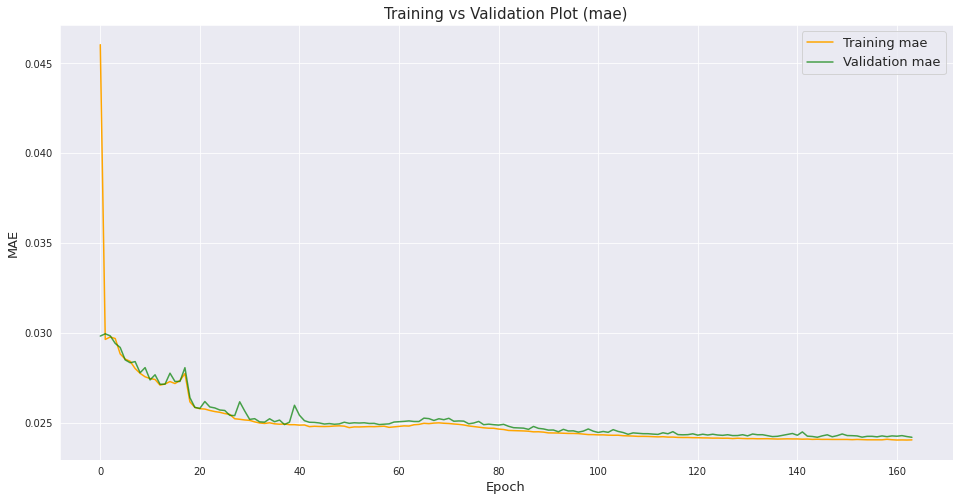

In [188]:
#Plot Loss
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(history.history['mae'], label = 'Training mae', color='orange')
ax.plot(history.history['val_mae'], label = 'Validation mae', color='g', alpha=0.7)

ax.set_title('Training vs Validation Plot (mae)', fontsize=15)
ax.set_ylabel('MAE', fontsize=13)
ax.set_xlabel('Epoch', fontsize=13)
ax.legend(fontsize=13)
ax.grid()


In [189]:
#Load the model weights from the checkpoint ('path_checkpoint' file)
try:
    autoencoder.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [190]:
result = autoencoder.evaluate(x= train_enc_Unsup_Train_Scaled, y= train_enc_Unsup_Train_Scaled)

2666/2666 [==============================] - 4s 2ms/step - loss: 0.0015 - mae: 0.0240


### Latent Space Representation

Plot of the latent space representation of the model. In other words, the plot shows the value of each data point produced by the neurons at the bottleneck of the network.

For this plot, it was used the original dataset (*df*) randomly undersampled to reach 2:1 ratio.

Even though the fraud samples are not completely separated, it is possible to note a different pattern and a tendency of agglutination.

In [205]:
import plotly.express as px
def plot_latent_space(encoder, df, n_legitimate=1000):

    ''' Plot the latent 3D space (Encoder's botleneck)'''

    #Get legitmate predictions and undersample
    norm_hid_rep = encoder.predict(scaler.transform(df[df['fraud']==0].drop(columns='fraud')))
    np.random.shuffle(norm_hid_rep)
    norm_hid_rep = norm_hid_rep[:n_legitimate]

    #Get fraudulent predictions
    fraud_hid_rep = encoder.predict(scaler.transform(df[df['fraud']==1].drop(columns='fraud')))

    #Generate plot
    df_fraud = pd.DataFrame(fraud_hid_rep, columns=['x', 'y', 'z'])
    df_fraud['class'] = 'Fraudulent'
    df_legit = pd.DataFrame(norm_hid_rep, columns=['x', 'y', 'z'])
    df_legit['class'] = 'Legitimate'
    df_plotly = pd.concat((df_fraud, df_legit), axis=0)

    fig = px.scatter_3d(df_plotly, x='x', y='y', z='z',
                        color = 'class',
                        color_discrete_sequence=['#FF0000', '#56ba89'],
                        opacity = 0.3,
                        width=1024, height=800)
    fig.show()

plot_latent_space(encoder, df)

## Unsupervised Learning

### Data Reconstruction and Threshold Set Up


In [192]:
#Using the train_enc_Sup set, we now feed the autoencoder model in order to get the reconstructions

def mse_df_generator(autoencoder, train_enc_Sup):
    '''Generate a MSE DaftaFrame - Original data vs Reconstructed data'''
    #Scale the data
    scaler = preprocessing.MinMaxScaler()
    train_enc_Sup_Scaled = scaler.fit_transform(train_enc_Sup.drop(columns='fraud'))

    #Get reconstructed values
    reconstructions = autoencoder.predict(train_enc_Sup_Scaled)

    #Computate the MSE error - Original values vs Recosntructed
    mse = np.mean(np.power(np.array(train_enc_Sup_Scaled) - reconstructions,2), axis=1)
    df_error = pd.DataFrame({'mse':mse, 'fraud':train_enc_Sup.fraud})

    #Display statisticas
    display(df_error.groupby('fraud').describe())

    return df_error

df_error = mse_df_generator(autoencoder, train_enc_Sup)

mse                      ...                              
          count      mean       std  ...       50%       75%       max
fraud                                ...                              
0      106618.0  0.024112  0.002155  ...  0.023732  0.024873  0.212700
1         184.0  0.035928  0.018003  ...  0.028729  0.037281  0.111013

[2 rows x 8 columns]

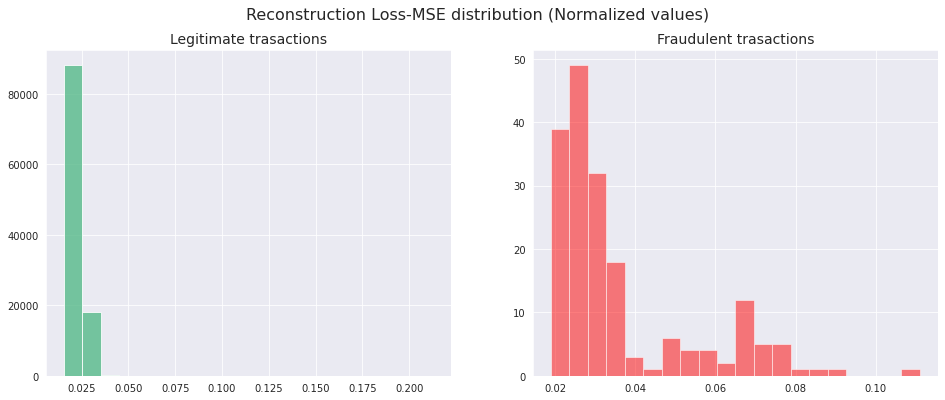

In [193]:
def plot_MSE_distributions(df_error):
    '''Plot MSE distributions for Fradulent and Legitimate trasactions.'''
    #Generate MSE plot for fraudulent vs leditimate transactions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.hist(df_error[df_error['fraud']==0]['mse'], bins = 20, color='#56ba89', alpha = 0.8)
    ax2.hist(df_error[df_error['fraud']==1]['mse'], bins = 20, color = 'red', alpha = 0.5)

    #Plot settings
    ax1.grid()
    ax2.grid()
    fig.suptitle('Reconstruction Loss-MSE distribution (Normalized values)', fontsize=16)
    ax1.set_title('Legitimate trasactions', fontsize=14)
    ax2.set_title('Fraudulent trasactions', fontsize=14)

plot_MSE_distributions(df_error)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106618
           1       0.41      0.22      0.29       184

    accuracy                           1.00    106802
   macro avg       0.71      0.61      0.64    106802
weighted avg       1.00      1.00      1.00    106802



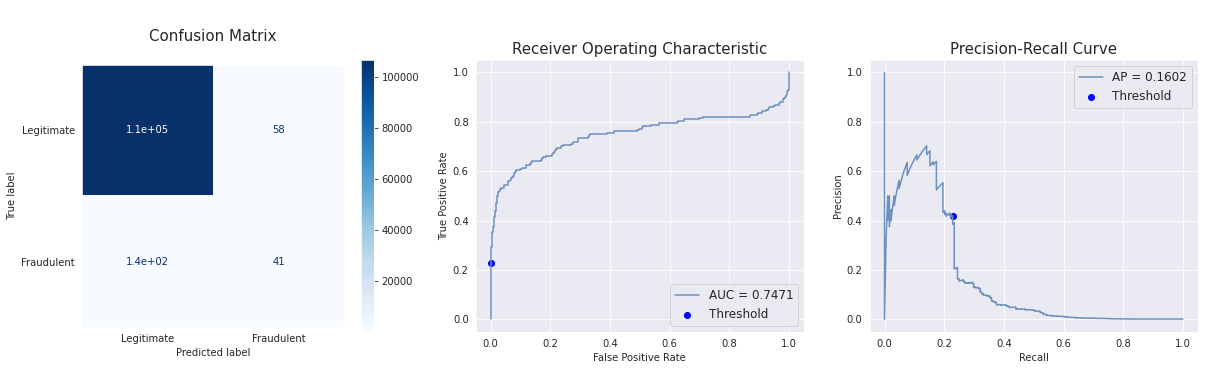

In [194]:
def auto_encoder_classify(df_error):
    '''
    Classify observations applying a threshold to MSE dataframe
    Threshold = MAX(f1-score)
    '''
    #Computate metrics - Precision-Recall
    precision_cls1, recall_cls1, thresholds_PR = precision_recall_curve(df_error.fraud, df_error.mse, pos_label=1)
    ap = sklearn.metrics.average_precision_score(df_error.fraud, df_error.mse)

    #Determine THRESHOLD (MAX f1-score)
    f1 = (2 * precision_cls1 * recall_cls1) / (precision_cls1 + recall_cls1)
    threshold_index = np.nanargmax(f1)
    threshold = thresholds_PR[threshold_index]

    #Computate metrics - ROC Curve
    fpr, tpr, thresholds_ROC = sklearn.metrics.roc_curve(df_error.fraud, df_error.mse)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    #Find threshold in ROC
    def find_nearest(array, value):
        array = np.asarray(array)
        index = (np.abs(array - value)).argmin()
        return index

    idx_roc = find_nearest(thresholds_ROC, threshold)

    #Apply Threshold
    df_error["preds"] = [1 if x > threshold else 0 for x in df_error["mse"]]

    #Display report
    print(classification_report(y_true=df_error.fraud, y_pred=df_error.preds))

#Generate Plots
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))

    #Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true=df_error.fraud, y_pred=df_error.preds), display_labels=['Legitimate','Fraudulent'])
    disp.plot(ax=ax1, cmap="Blues")

    #ROC Curve
    ax2.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    ax2.scatter(fpr[idx_roc], tpr[idx_roc], color='b', label='Threshold')

    #Precison-Recall Curve
    ax3.plot(recall_cls1, precision_cls1, label='AP = %0.4f'% ap)
    ax3.scatter(recall_cls1[threshold_index], precision_cls1[threshold_index], color='b', label='Threshold')

    #Plot settings
    ax1.set_title('\nConfusion Matrix\n', fontsize=15)

    ax2.set_title('\n\nReceiver Operating Characteristic', fontsize=15)
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid()
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    ax3.set_title('\n\nPrecision-Recall Curve', fontsize=15)
    ax3.legend(loc='upper right', fontsize=12)
    ax3.grid()
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Recall')




auto_encoder_classify(df_error)

### Model Evaluation

Now that the threshold is defined, it is possible to evaluate the model on the test set.

In [195]:
df_error_test = mse_df_generator(autoencoder, test_enc)

mse                      ...                              
         count      mean       std  ...       50%       75%       max
fraud                               ...                              
0      71079.0  0.010225  0.002381  ...  0.009887  0.010843  0.185564
1        123.0  0.026068  0.021866  ...  0.015494  0.030458  0.079130

[2 rows x 8 columns]

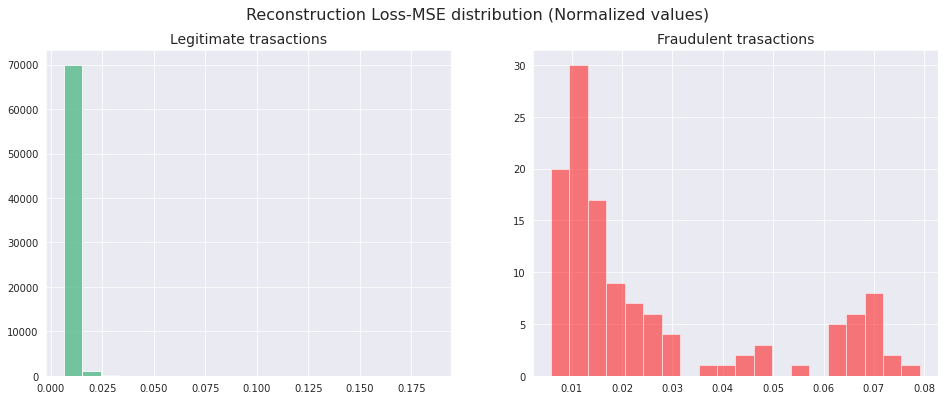

In [196]:
plot_MSE_distributions(df_error_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.51      0.22      0.31       123

    accuracy                           1.00     71202
   macro avg       0.75      0.61      0.65     71202
weighted avg       1.00      1.00      1.00     71202



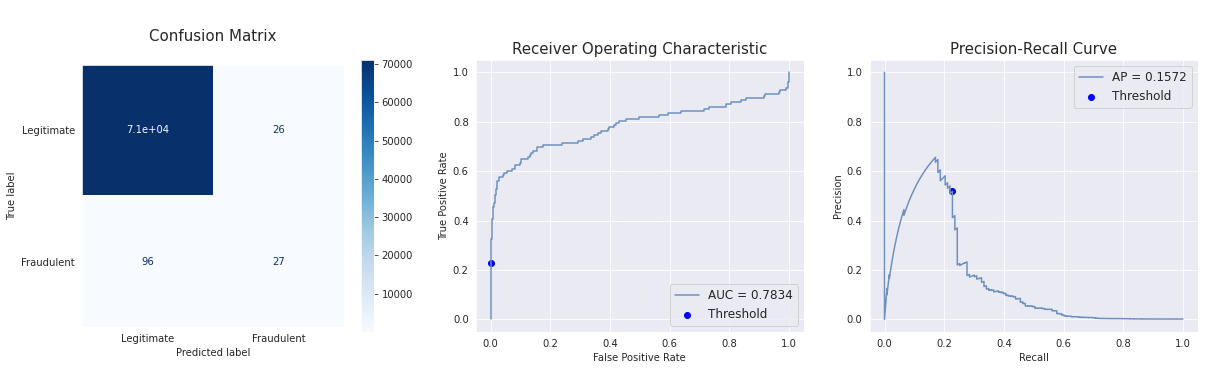

In [197]:
auto_encoder_classify(df_error_test)

## Semi-Supervise Learning




### Data Reconstruction

In [198]:
#Define training set
X_train_enc_Sup = train_enc_Sup.drop(columns='fraud')
y_train_enc_Sup = train_enc_Sup.fraud

#Define test set
X_test_enc = test_enc.drop(columns='fraud')
y_test_enc = test_enc.fraud

In [208]:
#Generating reconstructed sets

def get_reconstructions(autoencoder, data):
    
    '''Generate reconstructed sets'''
    
    #Scale the data
    scaler = preprocessing.MinMaxScaler()
    data_Scaled = scaler.fit_transform(data)

    #Get reconstructed values
    reconstructions = autoencoder.predict(data_Scaled)

    #Invert scale
    reconstructions = scaler.inverse_transform(reconstructions)

    return reconstructions


X_train_enc_Sup_recons = get_reconstructions(autoencoder, X_train_enc_Sup)
X_test_enc_recons = get_reconstructions(autoencoder, X_test_enc)

### Model Training

Best params:
{'estimator__max_depth': 20, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200, 'sampler1__sampling_strategy': 0.1, 'sampler2__sampling_strategy': 0.1}

Geometric Mean Score on test (G-mean): 0.297
Best score on train (f1-macro): 0.597

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.01      0.09      0.02       123

    accuracy                           0.99     71202
   macro avg       0.51      0.54      0.51     71202
weighted avg       1.00      0.99      0.99     71202



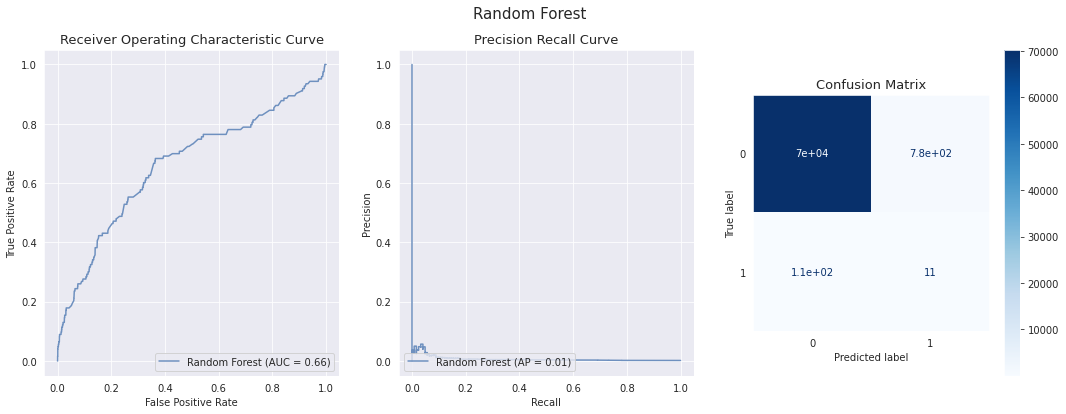

In [212]:
#-------------Model settings-------------------
estimator_name = 'Random Forest'
estimator = RandomForestClassifier(random_state=SEED, n_jobs=-1)
sampler1 = RandomUnderSampler(random_state=SEED)
sampler2 = combine.SMOTEENN(random_state=SEED)
metric_score = 'f1_macro'


params = {'sampler1__sampling_strategy': [0.01, 0.1],
          'sampler2__sampling_strategy': [0.1, 0.5, 1],
          'estimator__min_samples_split': [2,3],
          'estimator__min_samples_leaf': [4],
          'estimator__max_depth': [5,20,50,100,None],
          'estimator__n_estimators' : np.arange(150,250,50)
          }


run_classifier(X_train_enc_Sup_recons, y_train_enc_Sup,
               X_test_enc_recons, y_test,
               estimator,
               sampler1,
               sampler2,
               params,
               metric_score,
               estimator_name)

### Data Visualization

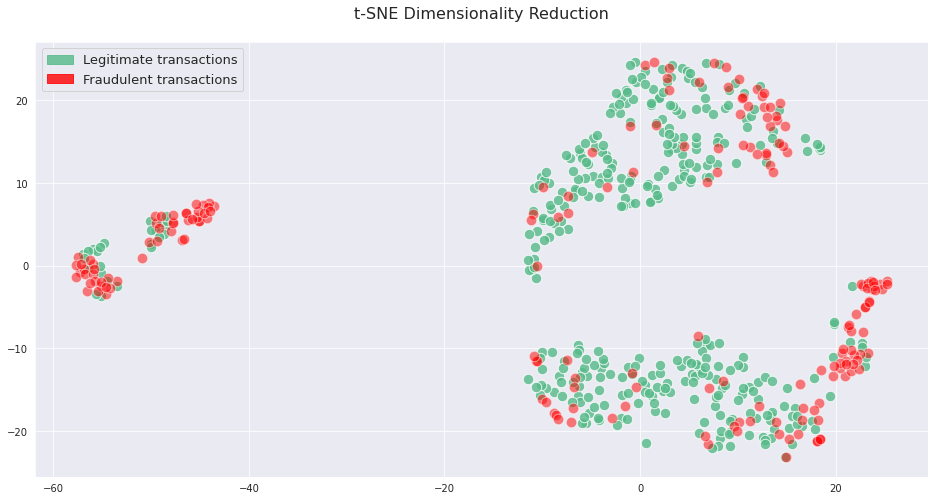

In [211]:
undersample_tnse = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
subset_undersample_tnse, subset_target_tsne = undersample_tnse.fit_resample(X_train_enc_Sup_recons, y_train_enc_Sup)

plot_tsne(subset_undersample_tnse, subset_target_tsne)

# Wrapping up
Dealing with anomalies, in this case credit card frauds, is especially hard because they are rare events. That means there is a huge amount of normal data available whereas just a few fraudulent observations. Thus we fall onto the classic tradeoff between precision and recall. For the credit card company point of view, it is not any good for the business to block legal transactions, although it is necessary to block all fraudulent operations. In other words, the predictive model must be as good as possible to minimize this errors, but there will always be some fine adjustments to be done by the business perspective with this regard.

<br>

## Unsupervised Learning - Anomaly Detection
In this category we have tested two algorithms, Isolation Forest and Local Outlier Factor. Both are classified as unsupervised learning, hence they do not need labeled data. In this case, the Isolation Forest achieved f1-macro score 30% higher than LOF. Both models are highly sensitive to the contamination parameter and that can be fine tuned according to the business preference on an training set. Another advantage for the Isolation Forest is the training time, the algorithm train much faster than LOF.

<br>

## Supervised Learning Classification

The grid search metric was capable of capturing a balanced and well distributed number of errors of each type (FP and FN). That can be seen in the Precision x Recall plots, the models are situated at an almost optimal point. With business knowledge, it is possible to adjust the model’s threshold to the point it is most interesting, leaning towards Precision or Recall.

Overall, all models performed quite well. A small advantage for the Random Forest Classifier regarding the metric adopted (f1-macro). The main point here is that the combination of over- and under-sampling methods has proven its efficiency. 


<br>

## Autoencoder - Unsupervised and Semi-Supervised Learning

The autoencoder model was successfully trained. However, different model architectures and hyperparameters combinations could be tested. There is still room for improvement. In the latent representation plot from the bottleneck neurons, it was possible to note some slightly different patterns regarding the fraudulent and legitimate observations. That means the model learned some of the intrinsic patterns from the legitimate transactions.

Regarding the classification using the MSE metric to differentiate fraudulent than non-fraudulent observations, the technique showed similar results to the Isolation Forest.

The Semi-Supervised learning on the other hand, underperformed, achieving results slight better than a base line model predicting only the majority class.

After investigating the t-SNE plot from the reconstructed observations, it possible to see that the autoencoder's output differs from the original samples. The t-SNE algorithm cannot cluster the fraudulent samples as good as it did before. The observations are probably agglutinated in the feature space now, which would explain the poor performance of the classifier.

<br>


## Overall

To sum up, the best fraud classification results were achieved by the Random Forest Classifier. It would be interesting to analyze how other ensemble classifiers would behave, like Ada Boost, XGBoost, etc.

Also, as commented above, the latent representation from the encoders model showed some potential to cluster the different classes. A suggestion for a next study would be to use an autoencoder model as a dimensionality reduction algorithm.
